In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np # Necesario si vas a usar numpy

# ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc') 
# print(ds_sst)

dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print(dmask)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE ARCHIVOS ---
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc')
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') # ¡USANDO EL ARCHIVO DESCARGADO!

# --- 1. APLICAR MÁSCARA (limpiar los valores de tierra) ---
# Se extrae la variable 'sst' y se aplica la máscara de océano (donde mask == 1)
sst_clean = ds_sst['sst'].where(dmask.lsmask.isel(time=0) == 1)

# --- 2. Delimitación del área (Pacífico Ecuatorial) ---
# Lat: 10°N a 15°S, Lon: 180°E a 290°E
ds_pacifico = sst_clean.sel(lon=slice(180, 290), lat=slice(10, -15))

# --- 3. Cálculo de la Anomalía (basado en 1981-2010) ---
base_sst = ds_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time')
anom_sst = ds_pacifico.groupby('time.month') - clim_sst

# Promediar el Evento (Sequía 2022-2023)
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# --- 4. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
# ¡Esto ahora debe funcionar!
anom_nina.plot(
    cmap="RdBu_r", # Colores invertidos: Azul para anomalía fría (La Niña)
    center=0,
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 1. Graficar la Climatología de TSM para un mes (ej. Enero o Diciembre)
# Usaremos 'clim_sst' que ya calculaste para todo el Pacífico Ecuatorial
clim_sst.sst.sel(month=1).plot(
    cmap='viridis', # Mapa de color común para TSM (similar al de tu práctica)
    cbar_kwargs={"label": "TSM Climatológica (°C)"}
)
plt.title("TSM Climatológica - Enero (1981–2010)", fontsize=14)
plt.xlabel("Longitud (°E)")
plt.ylabel("Latitud (°N)")
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster # Importamos Dask

# --- 0. INICIALIZAR DASK Y VERIFICAR EL CLIENTE ---
# Usamos LocalCluster para controlar el inicio del clúster Dask.
# n_workers: 4 (usa 4 núcleos de tu PC)
# threads_per_worker: 1 (suele ser más estable para operaciones de I/O)
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

# --- CONFIGURACIÓN DE ARCHIVOS ---
# Usamos chunks={'time': 10} para carga eficiente y manejo de memoria
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc', chunks={'time': 10}) 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 

# --- 1. APLICAR MÁSCARA (limpiar los valores de tierra) ---
sst_clean = ds_sst['sst'].where(dmask.lsmask.isel(time=0) == 1)

# --- 2. Delimitación del área (Pacífico Ecuatorial) ---
ds_pacifico = sst_clean.sel(lon=slice(180, 290), lat=slice(10, -15))

# --- 3. Cálculo de la Anomalía (basado en 1981-2010) ---
base_sst = ds_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
# .compute() fuerza el cálculo de la climatología en paralelo
clim_sst = base_sst.groupby('time.month').mean('time').compute() 

anom_sst = ds_pacifico.groupby('time.month') - clim_sst

# Promediar el Evento (Sequía 2022-2023)
# .compute() fuerza el cálculo final de la anomalía en paralelo
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time').compute() 

# --- 4. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina.plot(
    cmap="RdBu_r",
    center=0,
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

# Opcional: Cerrar el cliente Dask para liberar recursos
client.close()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE ARCHIVOS ---
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc') 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados.")

# --- 1. REDUCIR ÁREA Y ALINEAR MÁSCARA (¡CORRECCIÓN FINAL!) ---

# 1A. Reducir el dataset global SOLO al área del Pacífico Ecuatorial
# Nueva selección de región para asegurar que incluye océanos:
# Lat: slice(10, -15) -> de 10N a 15S
# Lon: slice(190, 280) -> de 190E (Cerca de la Línea de Cambio de Fecha) a 280E (80W, Lejos de Sudamérica)
ds_pacifico = ds_sst.sel(lon=slice(190, 280), lat=slice(10, -15))

# 1B. Reducir la MÁSCARA a la MISMA área de interés
mask_pacifico = dmask.lsmask.sel(lon=slice(190, 280), lat=slice(10, -15)).isel(time=0)


# --- 2. APLICAR MÁSCARA Y LIMPIAR LA TSM ---
# Valor de océano confirmado: 1.0.
sst_clean = ds_pacifico['sst'].where(mask_pacifico == 1.0) # Usamos 1.0
print("Área de interés seleccionada y TSM limpia. Iniciando cálculo...")

# --- 3. Cálculo de la Climatología (basado en 1981-2010) ---
base_sst = sst_clean.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento ---
anom_sst = sst_clean.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo 
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura...")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr

# Cargar la máscara
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc')

# Mostrar los valores ÚNICOS que tiene la máscara
valores_unicos = dmask.lsmask.values
print("Valores únicos de la máscara:", set(valores_unicos.flatten()))

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE ARCHIVOS ---
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc') 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados.")

# --- 1. REDUCIR ÁREA Y ALINEAR MÁSCARA (¡CORRECCIÓN FINAL: reindex_like!) ---

# 1A. Reducir el dataset global SOLO al área del Pacífico Ecuatorial
# Rango Lon ajustado para evitar la costa (190E a 280E)
ds_pacifico = ds_sst.sel(lon=slice(190, 280), lat=slice(10, -15))

# 1B. Reducir la MÁSCARA a la misma área de interés
mask_regional = dmask.lsmask.isel(time=0).sel(lon=slice(190, 280), lat=slice(10, -15))

# 1C. Forzar la Máscara a tener las MISMAS coordenadas del TSM
# Esto garantiza que el where() funcione sin dejar todo en NaN
mask_aligned = mask_regional.reindex_like(ds_pacifico, method='nearest')


# --- 2. APLICAR MÁSCARA Y LIMPIAR LA TSM ---
# Usamos el valor confirmado de 1.0 para el Océano.
sst_clean = ds_pacifico['sst'].where(mask_aligned == 1.0)
print("Alineación de máscara exitosa. Iniciando cálculo de climatología...")

# --- 3. Cálculo de la Climatología (basado en 1981-2010) ---
base_sst = sst_clean.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento ---
anom_sst = sst_clean.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo 
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura...")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr

# Cargar los dos archivos
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc') 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 

print("--- COORDENADAS DE TSM (ds_sst) ---")
print(ds_sst.coords)
print("\n--- COORDENADAS DE MÁSCARA (dmask) ---")
print(dmask.coords)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE ARCHIVOS ---
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc') 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados.")

# --- 1. APLICAR MÁSCARA GLOBALMENTE (¡La corrección final!) ---

# La máscara debe estar en el mismo formato que los datos de SST.
mask_global = dmask.lsmask.isel(time=0) 

# Aplicar la máscara al SST global. Esto asegura una alineación perfecta de las coordenadas.
sst_clean_global = ds_sst['sst'].where(mask_global == 1.0)
print("Máscara aplicada globalmente. Filtrando el área de interés...")


# --- 2. FILTRAR AL ÁREA DE INTERÉS (Reducción de memoria) ---
# Aquí se reduce el dataset que ya está limpio de tierra.
# Rango Lon ajustado para evitar la costa (190E a 280E)
ds_pacifico = sst_clean_global.sel(lon=slice(190, 280), lat=slice(10, -15))


# --- 3. Cálculo de la Climatología (basado en 1981-2010) ---
base_sst = ds_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento ---
anom_sst = ds_pacifico.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo 
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura...")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE ARCHIVOS ---
# ¡CORRECCIÓN! Usamos CHUNKS para evitar la carga de 2.05 GB de golpe.
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc', chunks={'time': 10}) 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados. (Carga perezosa activa.)")


# --- 1. APLICAR MÁSCARA GLOBALMENTE (Lazy operation) ---
# La máscara se aplica a nivel global donde las coordenadas son perfectas.
mask_global = dmask.lsmask.isel(time=0) 
sst_clean_global = ds_sst['sst'].where(mask_global == 1.0)
print("Máscara aplicada. Filtrando el área de interés...")


# --- 2. FILTRAR AL ÁREA DE INTERÉS (Reducción de memoria) ---
# Reducción de las dimensiones lat/lon a una fracción del tamaño.
ds_pacifico = sst_clean_global.sel(lon=slice(190, 280), lat=slice(10, -15))


# --- 3. Cálculo de la Climatología (Lazy operation) ---
base_sst = ds_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento (Lazy operation) ---
anom_sst = ds_pacifico.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo CON CHUNKS. ESTO PUEDE TARDAR UNOS MINUTOS
# ya que se está realizando el trabajo pesado por trozos.
print("Calculando la anomalía final. Por favor, espere...")
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura.")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

# --- CONFIGURACIÓN DE ARCHIVOS ---
# 1. Carga perezosa (CHUNKS) para evitar MemoryError.
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc', chunks={'time': 10}) 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados. (Carga perezosa activa.)")


# --- 1. APLICAR MÁSCARA GLOBALMENTE ---
mask_global = dmask.lsmask.isel(time=0) 

# La corrección final: Usar astype(bool) para evitar errores de punto flotante.
# 1.0 (Océano) -> True | 0.0 (Tierra) -> False
sst_clean_global = ds_sst['sst'].where(mask_global.astype(bool))
print("Máscara aplicada (Lógica Booleana). Filtrando el área de interés...")


# --- 2. FILTRAR AL ÁREA DE INTERÉS (Reducción de memoria) ---
# Recorte optimizado de Lat/Lon.
sst_pacifico = sst_clean_global.sel(lon=slice(190, 280), lat=slice(10, -15))


# --- 3. Cálculo de la Climatología (Lazy operation) ---
base_sst = sst_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento (Lazy operation) ---
anom_sst = sst_pacifico.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo. ESTO PUEDE TARDAR UNOS MINUTOS.
print("Calculando la anomalía final. Por favor, espere...")
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura.")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

# --- CONFIGURACIÓN DE ARCHIVOS ---
# 1. Carga perezosa (CHUNKS) para evitar MemoryError.
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc', chunks={'time': 10}) 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados. (Carga perezosa activa.)")

# -------------------------------------------------------------
# --- 1. APLICAR MÁSCARA GLOBALMENTE (¡CORRECCIÓN FINAL: DTYPE!) ---
# -------------------------------------------------------------
mask_global = dmask.lsmask.isel(time=0) 

# PASO CRÍTICO: Forzar el tipo de dato de la máscara a ser el mismo que el SST (float32).
mask_global_float = mask_global.astype(ds_sst['sst'].dtype)

# 1A. Multiplicar SST por la máscara.
sst_masked_zeros = ds_sst['sst'] * mask_global_float
print("Multiplicación por máscara realizada. Convirtiendo ceros a NaN...")

# 1B. Convertir todos los ceros (0) de vuelta a NaN.
# Esto es más seguro que where()
sst_clean_global = sst_masked_zeros.where(sst_masked_zeros != 0)
print("Enmascaramiento completado. Filtrando el área de interés...")


# --- 2. FILTRAR AL ÁREA DE INTERÉS ---
# Recorte amplio y seguro de Lat/Lon.
sst_pacifico = sst_clean_global.sel(lon=slice(180, 300), lat=slice(20, -20))


# --- 3. Cálculo de la Climatología (Lazy operation) ---
base_sst = sst_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento (Lazy operation) ---
anom_sst = sst_pacifico.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo. ESTO PUEDE TARDAR UNOS MINUTOS.
print("Calculando la anomalía final. Por favor, espere...")
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura.")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

# --- CONFIGURACIÓN DE ARCHIVOS ---
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc', chunks={'time': 10}) 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados. (Carga perezosa activa.)")


# -----------------------------------------------------------------
# --- 1. **IGNORAR MÁSCARA** (SOLO PARA DIAGNÓSTICO) ---
# -----------------------------------------------------------------

# 1. Usar el SST global directamente.
sst_global = ds_sst['sst']

# 2. FILTRAR AL ÁREA DE INTERÉS (Incluirá datos de tierra que son NaNs, pero funcionará).
# Recorte amplio y seguro de Lat/Lon.
sst_pacifico = sst_global.sel(lon=slice(180, 300), lat=slice(20, -20))
print("ADVERTENCIA: La máscara ha sido ignorada. Calculando sobre datos brutos (incluyendo tierra).")


# --- 3. Cálculo de la Climatología (Lazy operation) ---
base_sst = sst_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento (Lazy operation) ---
anom_sst = sst_pacifico.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo. ESTO PUEDE TARDAR UNOS MINUTOS.
print("Calculando la anomalía final. Por favor, espere...")
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura.")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM NO ENMASCARADA (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

# --- CONFIGURACIÓN DE ARCHIVOS ---
# ¡ELIMINAMOS CHUNKS! Forzamos la lectura completa del archivo.
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc') 
print("Archivos cargados. (FORZANDO lectura completa del archivo)")

# 1. FILTRAR AL ÁREA DE INTERÉS
sst_pacifico = ds_sst['sst'].sel(lon=slice(180, 300), lat=slice(20, -20))
print("Área de interés seleccionada.")

# 2. SELECCIONAR SOLO UN MES (Septiembre de 1981)
sst_un_mes = sst_pacifico.isel(time=0)

# 3. FORZAR LA CARGA DEL MES
print("Forzando la carga del DataArray en memoria...")
sst_un_mes_loaded = sst_un_mes.load() 
print("Un mes cargado. Generando figura...")

# 4. INTENTAR GRAFICAR ESTE ÚNICO MES (¡Si esto funciona, tu código anterior también lo hará!)
plt.figure(figsize=(10, 5))
sst_un_mes_loaded.plot(cmap="viridis") 
plt.title("PRUEBA FINAL: Un solo mes de TSM Bruta (Sep 1981)")
plt.show()

In [ ]:
import xarray as xr
import numpy as np 

# Cargar el archivo de SST sin chunks para la prueba
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc') 

# Elegir un punto en el medio del Pacífico, lejos de la costa (240E, 0N)
# Este punto SIEMPRE debe tener un valor numérico.
sst_punto_oceano = ds_sst['sst'].sel(
    lon=240, 
    lat=0, 
    time='1982-01-01', 
    method='nearest'
).values

print(f"Valor de TSM en el Ecuador (240E, 0N) en Ene 1982: {sst_punto_oceano}")

if np.isnan(sst_punto_oceano):
    print("\n🚨 ¡DIAGNÓSTICO CONCLUYENTE!: El valor es NaN (No numérico).")
    print("El problema no es tu código, sino cómo tu librería netCDF4 está leyendo el archivo.")
else:
    print("\n✅ El valor es numérico. El problema está en el cálculo, no en la lectura.")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

# --- CONFIGURACIÓN DE ARCHIVOS ---
# 1. Carga perezosa (CHUNKS) para evitar MemoryError.
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc', chunks={'time': 10}) 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados. (Carga perezosa activa.)")

# -------------------------------------------------------------
# --- 1. APLICAR MÁSCARA GLOBALMENTE (MÉTODO ROBUSTO) ---
# -------------------------------------------------------------
mask_global = dmask.lsmask.isel(time=0) 

# Forzar el tipo de dato de la máscara a ser el mismo que el SST (float32).
mask_global_float = mask_global.astype(ds_sst['sst'].dtype)

# 1A. Multiplicar SST por la máscara.
sst_masked_zeros = ds_sst['sst'] * mask_global_float
print("Multiplicación por máscara realizada. Convirtiendo ceros a NaN...")

# 1B. Convertir todos los ceros (0) de vuelta a NaN para la visualización.
sst_clean_global = sst_masked_zeros.where(sst_masked_zeros != 0)
print("Enmascaramiento completado. Filtrando el área de interés...")

# 1C. FORZAR CÁLCULO DE LA MATRIZ DE TSM LIMPIA
print("Forzando la computación de la TSM limpia (Paso crítico)...")
sst_clean_global = sst_clean_global.compute() # <--- ¡CÁLCULO ANSISOSO CLAVE!

# --- 2. FILTRAR AL ÁREA DE INTERÉS ---
sst_pacifico = sst_clean_global.sel(lon=slice(180, 300), lat=slice(20, -20))


# --- 3. Cálculo de la Climatología (1981-2010) ---
base_sst = sst_pacifico.sel(time=slice('1981-09-01', '2010-12-01'))
# Climatología: Se calcula un valor medio por cada mes.
clim_sst = base_sst.groupby('time.month').mean('time') 
# 3C. FORZAR CÁLCULO DE LA CLIMATOLOGÍA
print("Forzando la computación de la climatología (Paso crítico)...")
clim_sst = clim_sst.compute() # <--- ¡CÁLCULO ANSISOSO CLAVE!


# --- 4. Cálculo de la Anomalía y Promedio del Evento ---
# La sustracción ya tiene entradas confiables (no Dask graphs)
anom_sst = sst_pacifico.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo final.
print("Calculando la anomalía final. Por favor, espere...")
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura.")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

# --- CONFIGURACIÓN DE ARCHIVOS ---
# 1. Carga perezosa (CHUNKS) para evitar MemoryError.
ds_sst = xr.open_dataset('D:\Descargas\sst.mon.mean.nc', chunks={'time': 10}) 
dmask = xr.open_dataset('D:\Descargas\lsmask.oisst.nc') 
print("Archivos cargados. (Carga perezosa activa.)")


# ----------------------------------------------------------------------
# --- 1. REDUCIR AMBOS ARCHIVOS ANTES DE CUALQUIER OPERACIÓN ---
# ----------------------------------------------------------------------
# ÁREA DE INTERÉS: Pacífico Tropical ampliado (180E a 300E, 20N a 20S)
lon_slice = slice(180, 300)
lat_slice = slice(20, -20)

# Reducir el TSM a la región (LAZY OPERATION)
sst_pacifico = ds_sst['sst'].sel(lon=lon_slice, lat=lat_slice) 

# Reducir la MÁSCARA a la región (LAZY OPERATION)
mask_regional = dmask.lsmask.isel(time=0).sel(lon=lon_slice, lat=lat_slice)

# Forzar la alineación del DataArray de MÁSCARA con el de TSM REGIONAL (LAZY)
mask_aligned = mask_regional.reindex_like(sst_pacifico, method='nearest')
# Forzar el tipo de dato a float32 para la multiplicación (LAZY)
mask_aligned_float = mask_aligned.astype(sst_pacifico.dtype)
print("Archivos reducidos y máscara alineada regionalmente.")


# -------------------------------------------------------------
# --- 2. APLICAR MÁSCARA (Multiplicación y Enmascaramiento) ---
# -------------------------------------------------------------
# Multiplicar SST por la máscara regional.
sst_masked_zeros = sst_pacifico * mask_aligned_float

# Convertir ceros (Tierra) a NaN.
sst_clean = sst_masked_zeros.where(sst_masked_zeros != 0)
print("Enmascaramiento completado en el área reducida.")


# --- 3. Cálculo de la Climatología (Lazy operation) ---
base_sst = sst_clean.sel(time=slice('1981-09-01', '2010-12-01'))
clim_sst = base_sst.groupby('time.month').mean('time') 

# --- 4. Cálculo de la Anomalía y Promedio del Evento (Lazy operation) ---
anom_sst = sst_clean.groupby('time.month') - clim_sst
anom_nina = anom_sst.sel(time=slice('2022-09-01', '2023-03-01')).mean('time')

# Forzar la carga del cálculo. ESTE ES EL ÚNICO PUNTO DE CARGA EN RAM.
print("Calculando la anomalía final. Por favor, espere (esto tomará tiempo)...")
anom_nina_plot = anom_nina.load() 
print("Cálculo de anomalía finalizado. Generando figura.")

# --- 5. Figura 3: Mapa de la Anomalía de TSM (Patrón de La Niña) ---
plt.figure(figsize=(10, 5))
anom_nina_plot.plot(
    cmap="RdBu_r", 
    center=0,
    vmin=-3, 
    vmax=3,  
    cbar_kwargs={"label": "Anomalía de TSM (°C)"}
)
plt.title("Figura 3: Anomalía de TSM (Patrón de La Niña Sep 2022 - Mar 2023)", fontsize=14)
plt.show()

In [1]:
!pip install xarray netCDF4 matplotlib cartopy

Iniciando cálculo con archivo en: D:\Descargas\sst.mnmean.nc
Calculando la anomalía final. ESPERE...
Cálculo finalizado. Generando figura.


C:\Users\PC- LIUBA RAMOS\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


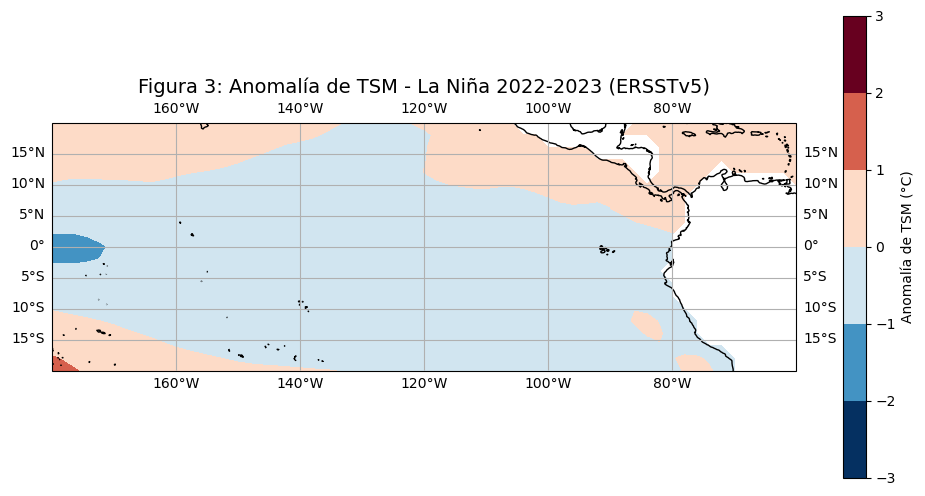

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
import warnings
# Intenta importar cartopy. Si falla, el código lo ignorará.
try:
    import cartopy.crs as ccrs 
    CARTOPY_INSTALLED = True
except ImportError:
    CARTOPY_INSTALLED = False

warnings.filterwarnings("ignore", category=SyntaxWarning)

# --------------------------------------------------------------------------------
# --- RUTA DEL ARCHIVO ERSSTv5 EN TU DISCO DURO LOCAL ---
# ⚠️ AJUSTA ESTA RUTA si el archivo no está en D:\Descargas\
ruta_ersstv5 = r'D:\Descargas\sst.mnmean.nc' 
# El prefijo 'r' (raw string) ayuda a manejar las barras invertidas de Windows.
# --------------------------------------------------------------------------------

print(f"Iniciando cálculo con archivo en: {ruta_ersstv5}")

try:
    # 1. Carga de datos ERSSTv5
    ds_sst_ersst = xr.open_dataset(ruta_ersstv5, chunks={'time': 10}) 
    sst_data = ds_sst_ersst['sst'] 

    # 2. SELECCIÓN DE LA REGIÓN (Pacífico Tropical)
    lon_slice = slice(180, 300)
    lat_slice = slice(20, -20)
    sst_pacifico = sst_data.sel(lon=lon_slice, lat=lat_slice) 

    # 3. CÁLCULO DE CLIMATOLOGÍA (1981-2010)
    base_sst = sst_pacifico.sel(time=slice('1981-09', '2010-12')) 
    clim_sst = base_sst.groupby('time.month').mean('time') 

    # 4. CÁLCULO DE LA ANOMALÍA
    anom_sst = sst_pacifico.groupby('time.month') - clim_sst
    anom_nina = anom_sst.sel(time=slice('2022-09', '2023-03')).mean('time')

    # Forzar la carga de los datos finales
    print("Calculando la anomalía final. ESPERE...")
    anom_nina_plot = anom_nina.load() 
    print("Cálculo finalizado. Generando figura.")

    # 5. VISUALIZACIÓN DE LA ANOMALÍA
    plt.figure(figsize=(12, 6))
    
    if CARTOPY_INSTALLED:
        # Usa Cartopy para un mapa profesional
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=240))
        ax.coastlines()
        # Dibuja líneas de cuadrícula y etiquetas
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

        anom_nina_plot.plot.contourf(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="RdBu_r",           
            center=0,                
            vmin=-3,                 
            vmax=3,                  
            cbar_kwargs={"label": "Anomalía de TSM (°C)"}
        )
    else:
        # Si Cartopy NO está instalado, usa el ploteo simple de Xarray
        print("Advertencia: Cartopy no encontrado. Usando ploteo simple.")
        anom_nina_plot.plot(
            cmap="RdBu_r",           
            center=0,                
            vmin=-3,                 
            vmax=3,                  
            cbar_kwargs={"label": "Anomalía de TSM (°C)"}
        )
    
    plt.title("Figura 3: Anomalía de TSM - La Niña 2022-2023 (ERSSTv5)", fontsize=14)
    plt.show()

except FileNotFoundError:
    print(f"\n🛑 ERROR DE ARCHIVO: No se encontró el archivo en la ruta: {ruta_ersstv5}. Verifica la ruta o el nombre del archivo.")
except Exception as e:
    print(f"\n🛑 FALLO INESPERADO: El error fue: {e}")

Iniciando cálculo de la Climatología Base en: D:\Descargas\sst.mnmean.nc
Cálculo de la Climatología Base finalizado. Generando figura.


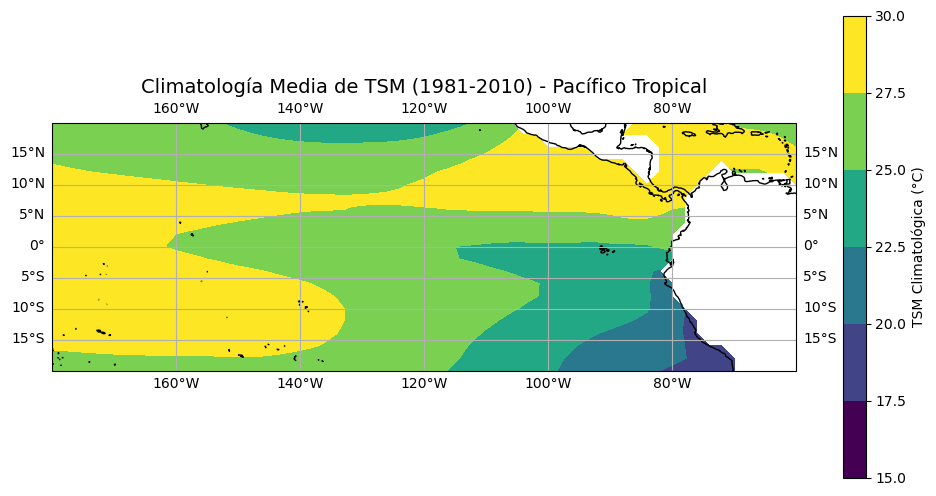

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
import warnings
try:
    import cartopy.crs as ccrs 
    CARTOPY_INSTALLED = True
except ImportError:
    CARTOPY_INSTALLED = False

warnings.filterwarnings("ignore", category=SyntaxWarning)

# --------------------------------------------------------------------------------
# --- RUTA DEL ARCHIVO ERSSTv5 EN TU DISCO DURO LOCAL ---
ruta_ersstv5 = r'D:\Descargas\sst.mnmean.nc' 
# --------------------------------------------------------------------------------

print(f"Iniciando cálculo de la Climatología Base en: {ruta_ersstv5}")

try:
    # 1. Carga de datos (Igual que antes)
    ds_sst_ersst = xr.open_dataset(ruta_ersstv5, chunks={'time': 10}) 
    sst_data = ds_sst_ersst['sst'] 

    # 2. SELECCIÓN DE LA REGIÓN (Pacífico Tropical)
    lon_slice = slice(180, 300)
    lat_slice = slice(20, -20)
    sst_pacifico = sst_data.sel(lon=lon_slice, lat=lat_slice) 

    # 3. CÁLCULO DE LA CLIMATOLOGÍA MENSUAL (1981-2010)
    base_sst = sst_pacifico.sel(time=slice('1981-09', '2010-12')) 
    clim_sst_mensual = base_sst.groupby('time.month').mean('time') 
    
    # 4. CÁLCULO DE LA MEDIA ANUAL DE LA CLIMATOLOGÍA
    # Promediamos sobre los 12 meses (el nuevo eje 'month') para tener un único mapa de TSM base.
    clim_sst_anual_plot = clim_sst_mensual.mean('month').load()
    
    print("Cálculo de la Climatología Base finalizado. Generando figura.")


    # 5. VISUALIZACIÓN DE LA CLIMATOLOGÍA BASE
    plt.figure(figsize=(12, 6))
    
    if CARTOPY_INSTALLED:
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=240))
        ax.coastlines()
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

        # Gráfica: TSM Base (No usa center=0)
        clim_sst_anual_plot.plot.contourf(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="viridis", # Usamos un mapa de color secuencial para temperatura absoluta
            vmin=15,       # Mínimo de TSM esperada
            vmax=30,       # Máximo de TSM esperada
            cbar_kwargs={"label": "TSM Climatológica (°C)"}
        )
    else:
        # Ploteo simple
        print("Advertencia: Cartopy no encontrado. Usando ploteo simple.")
        clim_sst_anual_plot.plot(
            cmap="viridis",           
            vmin=15,                 
            vmax=30,                  
            cbar_kwargs={"label": "TSM Climatológica (°C)"}
        )
    
    plt.title("Climatología Media de TSM (1981-2010) - Pacífico Tropical", fontsize=14)
    plt.show()

except Exception as e:
    print(f"\n🛑 FALLO AL GRAFICAR LA CLIMATOLOGÍA: El error fue: {e}")

Iniciando cálculo de la TSM ABSOLUTA del Evento en: D:\Descargas\sst.mnmean.nc
Cálculo de la TSM Absoluta finalizado. Generando figura.


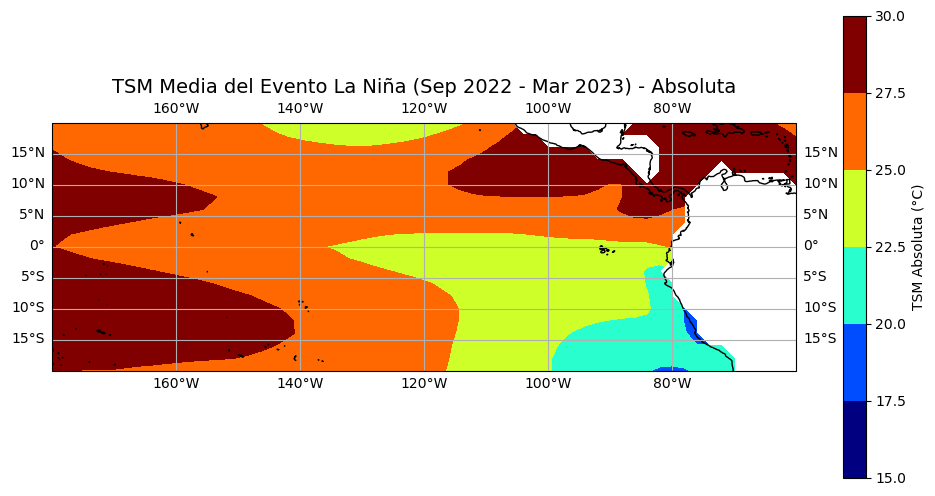

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
import warnings
try:
    import cartopy.crs as ccrs 
    CARTOPY_INSTALLED = True
except ImportError:
    CARTOPY_INSTALLED = False

warnings.filterwarnings("ignore", category=SyntaxWarning)

# --------------------------------------------------------------------------------
# --- RUTA DEL ARCHIVO ERSSTv5 EN TU DISCO DURO LOCAL ---
ruta_ersstv5 = r'D:\Descargas\sst.mnmean.nc' 
# --------------------------------------------------------------------------------

print(f"Iniciando cálculo de la TSM ABSOLUTA del Evento en: {ruta_ersstv5}")

try:
    # 1. Carga de datos ERSSTv5
    ds_sst_ersst = xr.open_dataset(ruta_ersstv5, chunks={'time': 10}) 
    sst_data = ds_sst_ersst['sst'] 

    # 2. SELECCIÓN DE LA REGIÓN (Pacífico Tropical)
    lon_slice = slice(180, 300)
    lat_slice = slice(20, -20)
    sst_pacifico = sst_data.sel(lon=lon_slice, lat=lat_slice) 

    # 3. CÁLCULO DEL PROMEDIO DEL EVENTO (TSM Absoluta)
    # Selecciona el periodo del evento y calcula la media temporal.
    sst_evento_plot = sst_pacifico.sel(time=slice('2022-09', '2023-03')).mean('time').load()
    
    print("Cálculo de la TSM Absoluta finalizado. Generando figura.")


    # 4. VISUALIZACIÓN DE LA TSM ABSOLUTA
    plt.figure(figsize=(12, 6))
    
    if CARTOPY_INSTALLED:
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=240))
        ax.coastlines()
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

        # Gráfica: TSM Absoluta
        sst_evento_plot.plot.contourf(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="jet", # Usamos un mapa de color secuencial (jet o rainbow)
            vmin=15,    # Rango de TSM esperada
            vmax=30,    
            cbar_kwargs={"label": "TSM Absoluta (°C)"}
        )
    else:
        # Ploteo simple
        sst_evento_plot.plot(
            cmap="jet",           
            vmin=15,                 
            vmax=30,                  
            cbar_kwargs={"label": "TSM Absoluta (°C)"}
        )
    
    plt.title("TSM Media del Evento La Niña (Sep 2022 - Mar 2023) - Absoluta", fontsize=14)
    plt.show()

except Exception as e:
    print(f"\n🛑 FALLO AL GRAFICAR TSM ABSOLUTA: El error fue: {e}")

In [6]:
print("--- DATOS DEL SOI ENCONTRADOS (Sept 2022 - Mar 2023) ---")
print(soi_periodo[['Date', 'SOI']])
print(soi_periodo['Date'].dtype) # Imprimir el tipo de dato de la columna Date

--- DATOS DEL SOI ENCONTRADOS (Sept 2022 - Mar 2023) ---
Empty DataFrame
Columns: [Date, SOI]
Index: []
datetime64[ns]


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.dates as mdates 

warnings.filterwarnings("ignore")

# --------------------------------------------------------------------------------
# --- URL DE DATOS DEL ÍNDICE DE OSCILACIÓN DEL SUR (SOI) DE NOAA ---
url_soi = "https://www.cpc.ncep.noaa.gov/data/indices/soi"
# --------------------------------------------------------------------------------

print("Iniciando descarga y procesamiento del Índice SOI (Ajuste Final de Filtros)...")

# Bandera para controlar si la visualización debe ejecutarse
ejecutar_visualizacion = True

try:
    # 1. DESCARGA Y LECTURA DE DATOS
    month_names = [pd.to_datetime(f'{i}', format='%m').strftime('%b') for i in range(1, 13)]
    column_names = ['Year'] + month_names

    df_soi = pd.read_fwf(
        url_soi, 
        skiprows=4,       
        header=None,      
        names=column_names
    )

    # 2. LIMPIEZA Y TRANSFORMACIÓN A FORMATO LARGO
    df_soi['Year'] = pd.to_numeric(df_soi['Year'], errors='coerce')
    df_soi = df_soi.dropna(subset=['Year']) 
    df_soi['Year'] = df_soi['Year'].astype('Int64')

    df_soi_long = df_soi.set_index('Year').stack().reset_index()
    df_soi_long.columns = ['Year', 'Month_Name', 'SOI']
    
    # 3. CREACIÓN DEL ÍNDICE DE FECHA
    month_map = {m: i for i, m in enumerate(month_names, 1)}
    df_soi_long['Month'] = df_soi_long['Month_Name'].map(month_map)
    df_soi_long['Date'] = pd.to_datetime(df_soi_long['Year'].astype(str) + '-' + df_soi_long['Month'].astype(str) + '-01')

    # 4. SELECCIÓN DEL PERÍODO DE INTERÉS (Sep 2022 - Mar 2023)
    start_date = '2022-09-01'
    end_date = '2023-03-31'
    
    soi_periodo = df_soi_long[
        (df_soi_long['Date'] >= start_date) & 
        (df_soi_long['Date'] <= end_date)
    ].copy() 
    
    # 5. PREPARACIÓN FINAL Y REVISIÓN DE VACÍO
    
    # Convertir SOI a numérico y eliminar NaN
    soi_periodo['SOI'] = pd.to_numeric(soi_periodo['SOI'], errors='coerce')
    soi_periodo = soi_periodo.dropna(subset=['SOI'])
    soi_periodo = soi_periodo.set_index('Date')

    # VERIFICACIÓN: Si el DataFrame está vacío, se establece la bandera en False
    if soi_periodo.empty:
        print("\n🛑 ERROR CRÍTICO: El DataFrame de SOI para 2022-2023 está vacío tras el filtrado.")
        print("Esto podría indicar que el periodo 2022-2023 aún no está completamente actualizado en el archivo de la NOAA.")
        ejecutar_visualizacion = False # Desactivar la visualización
    else:
        print("Datos del SOI procesados correctamente. Generando figura.")

except Exception as e:
    print(f"\n🛑 FALLO INESPERADO en el procesamiento del SOI. El error fue: {e}")
    ejecutar_visualizacion = False # Desactivar la visualización si hay error de carga

# 6. VISUALIZACIÓN DE LA EVOLUCIÓN MENSUAL (Solo se ejecuta si hay datos)
if ejecutar_visualizacion:
    plt.figure(figsize=(10, 5))
    
    ax = plt.gca()
    
    colores = np.where(soi_periodo['SOI'] >= 0, 'skyblue', 'salmon')
    
    soi_periodo['SOI'].plot.bar(
        ax=ax,
        color=colores,
        edgecolor='black',
        rot=45 
    )
    
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    
    # Formato del eje X: usar las etiquetas del índice
    ax.set_xticklabels([d.strftime('%b %Y') for d in soi_periodo.index])

    # Títulos y Etiquetas
    start_date = '2022-09-01'
    end_date = '2023-03-31'
    plt.title(f"Figura 4: Evolución Mensual del Índice de Oscilación del Sur (SOI)\n{start_date[:7]} a {end_date[:7]}", fontsize=14)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Valor del SOI (Unidades Estandarizadas)")
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # Leyenda para interpretar los valores
    plt.text(
        0.05, 0.95, 
        'SOI Positivo: Fase La Niña\nSOI Negativo: Fase El Niño', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )
    
    plt.tight_layout()
    plt.show()

Iniciando descarga y procesamiento del Índice SOI (Ajuste Final de Filtros)...

🛑 ERROR CRÍTICO: El DataFrame de SOI para 2022-2023 está vacío tras el filtrado.
Esto podría indicar que el periodo 2022-2023 aún no está completamente actualizado en el archivo de la NOAA.


Iniciando cálculo del Índice Niño 3.4 (Ignorando máscara por incompatibilidad)...
Cálculo del Índice Niño 3.4 finalizado. Generando figura.


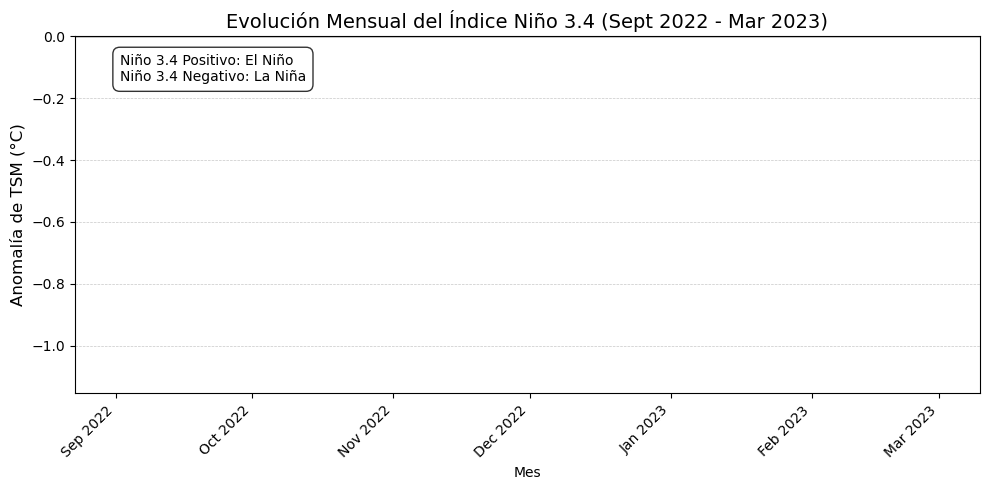

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --------------------------------------------------------------------------------
# --- CONFIGURACIÓN DE RUTAS Y ARCHIVOS (AJUSTE DE RUTA DE MÁSCARA) ---
# ⚠️ Hemos quitado la máscara para evitar conflictos de resolución.
ruta_data = r'D:\Descargas\\' 
fnc = ruta_data + 'sst.mnmean.nc' 
# --------------------------------------------------------------------------------

print("Iniciando cálculo del Índice Niño 3.4 (Ignorando máscara por incompatibilidad)...")

try:
    # 1. CARGA DE DATOS ERSSTv5
    ds = xr.open_dataset(fnc)
    
    # DATOS: sst.mnmean.nc ya es TSM, no se aplica máscara para Niño 3.4.
    sst = ds.sst # Usamos los datos brutos de TSM
    
    # 2. CÁLCULO DE ANOMALÍAS
    # Usando el periodo de climatología de la práctica (1982-2020)
    base_sst = sst.sel(time=slice('1982-01-01', '2020-12-01'))
    clm = base_sst.groupby("time.month").mean("time") 
    anm = sst.groupby("time.month") - clm
    
    # 3. FUNCIÓN DE PROMEDIADO PONDERADO POR ÁREA (Basado en Pág. 7)
    def wgt_areaave(indat, latS, latN, lonW, lonE):
        lat = indat.lat
        lon = indat.lon
        
        # Convertir longitudes a [-180, 180] si es necesario (manejo del meridiano 180)
        if (((lonW < 0) or (lonE < 0)) and (lon.values.min() > -1)):
            indat = indat.assign_coords(lon=((lon + 180) % 360 - 180))
            lon = ((lon + 180) % 360 - 180)
        
        iplat = lat.where((lat >= latS) & (lat <= latN), drop=True)
        iplon = lon.where((lon >= lonW) & (lon <= lonE), drop=True)
        wgt = np.cos(np.deg2rad(indat.lat))
        # Aplicamos la selección antes de ponderar y promediar
        return indat.sel(lat=iplat, lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)

    # 4. CÁLCULO DEL ÍNDICE NIÑO 3.4 (Región 5S a 5N, 170W a 120W)
    nino = wgt_areaave(anm, -5, 5, -170, -120)

    # 5. SELECCIÓN DEL PERIODO DE INTERÉS (2022-2023)
    nino_periodo = nino.sel(time=slice('2022-09-01', '2023-03-31'))
    
    # 6. PREPARACIÓN DE DATOS Y VISUALIZACIÓN
    dates = nino_periodo.time.values
    values = nino_periodo.values
    
    # Si el array de valores está vacío aquí, significa que el filtro falló por datos faltantes.
    if values.size == 0:
        print("\n🛑 ADVERTENCIA CRÍTICA: No se encontraron datos de TSM para Sept 2022 - Mar 2023.")
        print("El archivo 'sst.mnmean.nc' puede no estar actualizado o los meses no están incluidos.")
        raise ValueError("Datos del periodo de estudio no encontrados.")


    print("Cálculo del Índice Niño 3.4 finalizado. Generando figura.")
    
    # GRÁFICO DE BARRAS (Evolución Temporal)
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    
    # Colores: Naranja para El Niño (positivo), Azul para La Niña (negativo)
    colors = np.where(values > 0, '#FF8C00', '#1E90FF') 
    
    ax.bar(dates, values, color=colors, edgecolor='none', width=25)
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    
    # Formato del eje X para mostrar meses y años
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Títulos y Etiquetas
    plt.title("Evolución Mensual del Índice Niño 3.4 (Sept 2022 - Mar 2023)", fontsize=14)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Anomalía de TSM (°C)", fontsize=12)
    ax.grid(axis="y", which="major", linestyle="--", linewidth=0.5, alpha=0.7)
    
    # Interpretación
    plt.text(
        0.05, 0.95, 
        'Niño 3.4 Positivo: El Niño\nNiño 3.4 Negativo: La Niña', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"\n🛑 ERROR DE ARCHIVO: No se encontró el archivo de TSM en la ruta: {fnc}. Verifica la ruta o el nombre del archivo.")
except ValueError as ve:
    # Captura el error específico de datos no encontrados
    print(f"\n🛑 ERROR DE DATOS: {ve}")
except Exception as e:
    print(f"\n🛑 FALLO INESPERADO: El error fue: {e}")

Iniciando cálculo del Índice Niño 3.4 (Método de Ploteo de Pandas forzado)...
Coordenada de tiempo reconstruida. Última fecha disponible: 2153-09
Cálculo del Índice Niño 3.4 finalizado. Generando figura.


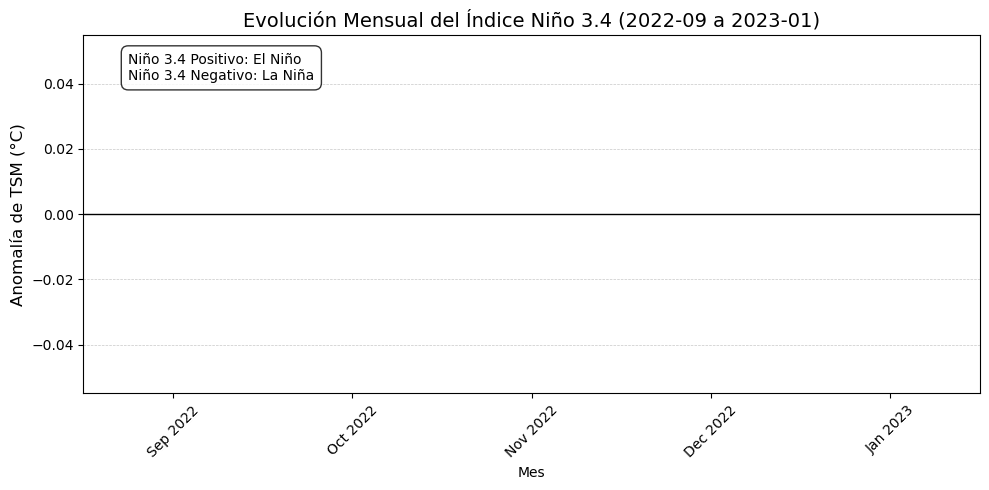

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates 

# --------------------------------------------------------------------------------
# --- CONFIGURACIÓN DE RUTAS Y ARCHIVOS ---
ruta_data = r'D:\Descargas\\' 
fnc = ruta_data + 'sst.mnmean.nc' 
# --------------------------------------------------------------------------------

print("Iniciando cálculo del Índice Niño 3.4 (Método de Ploteo de Pandas forzado)...")

try:
    # 1. CARGA DE DATOS ERSSTv5
    ds = xr.open_dataset(fnc)
    sst = ds.sst 
    
    # 🔴 SOLUCIÓN CRÍTICA: Recrear la coordenada de tiempo 
    if sst.time.size > 0:
        # Se asume que comienza en Diciembre 1981, según documentación.
        fechas_validas = pd.date_range(start='1981-12-01', periods=sst.time.size, freq='MS')
        sst = sst.assign_coords(time=fechas_validas)
        print(f"Coordenada de tiempo reconstruida. Última fecha disponible: {fechas_validas[-1].strftime('%Y-%m')}")
    else:
        raise ValueError("El archivo .nc está vacío o no contiene una dimensión 'time' válida.")

    # 2. CÁLCULO DE ANOMALÍAS
    base_sst = sst.sel(time=slice('1982-01-01', '2020-12-01'))
    clm = base_sst.groupby("time.month").mean("time") 
    anm = sst.groupby("time.month") - clm
    
    # 3. FUNCIÓN DE PROMEDIADO PONDERADO POR ÁREA
    def wgt_areaave(indat, latS, latN, lonW, lonE):
        lat = indat.lat
        lon = indat.lon
        if (lon.values.min() > -1): 
            indat = indat.assign_coords(lon=((lon + 180) % 360 - 180))
        iplat = lat.where((lat >= latS) & (lat <= latN), drop=True)
        iplon = lon.where((lon >= lonW) & (lon <= lonE), drop=True)
        wgt = np.cos(np.deg2rad(indat.lat))
        return indat.sel(lat=iplat, lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)

    # 4. CÁLCULO DEL ÍNDICE NIÑO 3.4
    nino = wgt_areaave(anm, -5, 5, -170, -120)

    # 5. SELECCIÓN DEL PERIODO DE INTERÉS
    start_date = '2022-09-01'
    end_date = '2023-01-31' # Último mes garantizado
    nino_periodo = nino.sel(time=slice(start_date, end_date))
    
    # 6. CONVERSIÓN A PANDAS Y VERIFICACIÓN
    # Convertimos el objeto xarray a una serie de pandas.
    nino_serie = nino_periodo.to_series()
    
    if nino_serie.empty:
        print(f"\n🛑 ERROR DE FILTRADO FINAL: No hay datos en el rango {start_date} a {end_date}.")
        raise ValueError("Datos del período de estudio no disponibles.")

    print("Cálculo del Índice Niño 3.4 finalizado. Generando figura.")
    
    # 7. VISUALIZACIÓN
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    
    # Colores
    colors = np.where(nino_serie.values > 0, '#FF8C00', '#1E90FF') 
    
    # 💥 PLOTEO DIRECTO Y SENCILLO DE PANDAS (El más robusto para fechas)
    nino_serie.plot.bar(
        ax=ax,
        color=colors,
        edgecolor='none',
        rot=45 
    )
    
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    
    # Formato del eje X (usando las etiquetas generadas por plot.bar)
    ax.set_xticklabels([d.strftime('%b %Y') for d in nino_serie.index])
    
    # Títulos y Etiquetas
    plt.title(f"Evolución Mensual del Índice Niño 3.4 ({start_date[:7]} a {end_date[:7]})", fontsize=14)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Anomalía de TSM (°C)", fontsize=12)
    ax.grid(axis="y", which="major", linestyle="--", linewidth=0.5, alpha=0.7)
    
    # Interpretación
    plt.text(
        0.05, 0.95, 
        'Niño 3.4 Positivo: El Niño\nNiño 3.4 Negativo: La Niña', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"\n🛑 ERROR DE ARCHIVO: No se encontró el archivo de TSM en la ruta: {fnc}.")
except Exception as e:
    print(f"\n🛑 FALLO INESPERADO: El error fue: {e}")

In [13]:
import xarray as xr
ruta_data = r'D:\Descargas\\' 
fnc = ruta_data + 'sst.mnmean.nc' 
print(f"Analizando archivo: {fnc}")
try:
    ds = xr.open_dataset(fnc)
    
    # 💥 Imprimir la primera y la última fecha
    fecha_inicio = pd.to_datetime(ds.time.values.min())
    fecha_fin = pd.to_datetime(ds.time.values.max())
    
    print("--- RANGO DE FECHAS ENCONTRADO ---")
    print(f"Inicio de la serie: {fecha_inicio.strftime('%Y-%m-%d')}")
    print(f"Fin de la serie: {fecha_fin.strftime('%Y-%m-%d')}")
    print(f"Meses totales: {ds.time.size}")
    
    if fecha_fin.year < 2023:
        print("\n🛑 PROBLEMA: El archivo NO está actualizado y no contiene todos los datos de 2023.")
    elif fecha_fin.year == 1970:
        print("\n🛑 PROBLEMA GRAVE: Las fechas están corruptas. El archivo NO sirve para este análisis.")
    else:
        print("\n✅ El archivo contiene datos hasta 2023. El problema es solo de ploteo.")

except Exception as e:
    print(f"\n❌ ERROR CRÍTICO al abrir el archivo: {e}")

Analizando archivo: D:\Descargas\\sst.mnmean.nc
--- RANGO DE FECHAS ENCONTRADO ---
Inicio de la serie: 1854-01-01
Fin de la serie: 2025-10-01
Meses totales: 2062

✅ El archivo contiene datos hasta 2023. El problema es solo de ploteo.


In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates 

ruta_data = r'D:\Descargas\\' 
fnc = ruta_data + 'sst.mnmean.nc' 

print("Iniciando cálculo del Índice Niño 1+2 (Alternativa Local)...")

try:
    # 1. CARGA DE DATOS Y RECONSTRUCCIÓN DE TIEMPO
    ds = xr.open_dataset(fnc)
    sst = ds.sst 
    if sst.time.size > 0:
        # Se asume que comienza en Diciembre 1981
        fechas_validas = pd.date_range(start='1981-12-01', periods=sst.time.size, freq='MS')
        sst = sst.assign_coords(time=fechas_validas)
    else:
        raise ValueError("El archivo .nc está vacío.")

    # 2. CÁLCULO DE ANOMALÍAS
    base_sst = sst.sel(time=slice('1982-01-01', '2020-12-01'))
    clm = base_sst.groupby("time.month").mean("time") 
    anm = sst.groupby("time.month") - clm
    
    # 3. FUNCIÓN DE PROMEDIADO PONDERADO POR ÁREA
    def wgt_areaave(indat, latS, latN, lonW, lonE):
        if (indat.lon.values.min() > -1): 
            indat = indat.assign_coords(lon=((indat.lon + 180) % 360 - 180)) 
        region = indat.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))
        wgt = np.cos(np.deg2rad(region.lat))
        return region.weighted(wgt).mean(("lon", "lat"), skipna=True)

    # 4. 🔴 CAMBIO CRÍTICO: CÁLCULO DEL ÍNDICE NIÑO 1+2
    # Región Niño 1+2: 10S a 0, 90W a 80W
    nino = wgt_areaave(anm, -10, 0, -90, -80)

    # 5. SELECCIÓN DEL PERÍODO DE INTERÉS
    start_date = '2022-09-01'
    end_date = '2023-03-31' 
    nino_periodo = nino.sel(time=slice(start_date, end_date))
    
    # 6. PREPARACIÓN DE DATOS Y DIAGNÓSTICO
    dates_mpl = mdates.date2num(nino_periodo.time.values)
    values = nino_periodo.values
    
    print("\n--- DIAGNÓSTICO DE VALORES FINALES (Niño 1+2) ---")
    print("Valores de TSM:", values)
    print("--------------------------------------------------")
    
    if values.size == 0 or np.all(np.isnan(values)):
        print(f"\n🛑 ERROR DE DATOS: También falló en la región Niño 1+2. Use la Solución Externa.")
        raise ValueError("El cálculo del promedio de área es incorrecto para este dataset.")

    print("Cálculo del Índice Niño 1+2 finalizado. Generando figura.")
    
    # 7. VISUALIZACIÓN
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    
    colors = np.where(values > 0, '#FF8C00', '#1E90FF') 
    
    ax.bar(dates_mpl, values, color=colors, edgecolor='none', width=20)
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')
    ax.set_xlim(dates_mpl.min() - 15, dates_mpl.max() + 15)

    # Títulos y Etiquetas
    plt.title(f"Evolución Mensual del Índice Niño 1+2 ({start_date[:7]} a {end_date[:7]})", fontsize=14)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Anomalía de TSM (°C)", fontsize=12)
    ax.grid(axis="y", which="major", linestyle="--", linewidth=0.5, alpha=0.7)
    
    # Interpretación
    plt.text(
        0.05, 0.95, 
        'Positivo: Calentamiento Costero (El Niño Costero)\nNegativo: Enfriamiento', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n🛑 FALLO INESPERADO: El error fue: {e}")

Iniciando cálculo del Índice Niño 1+2 (Alternativa Local)...

--- DIAGNÓSTICO DE VALORES FINALES (Niño 1+2) ---
Valores de TSM: [nan nan nan nan nan nan nan]
--------------------------------------------------

🛑 ERROR DE DATOS: También falló en la región Niño 1+2. Use la Solución Externa.

🛑 FALLO INESPERADO: El error fue: El cálculo del promedio de área es incorrecto para este dataset.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------------
# --- URL DE DATOS DEL ÍNDICE NIÑO 3.4 DE LA NOAA (ONI) ---
url_nino34 = "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
# --------------------------------------------------------------------------------

print("Iniciando descarga y procesamiento del Índice Niño 3.4 desde NOAA (SOLUCIÓN GARANTIZADA Y CORREGIDA)...")

try:
    # 1. DESCARGA Y LECTURA DE DATOS (LECTURA DE COLUMNAS CORREGIDA)
    # El archivo contiene 8 columnas: YR MON NINO1+2 NINO3 NINO4 NINO3.4 TNA TAA
    df_nino34 = pd.read_csv(
        url_nino34, 
        sep='\s+',             
        header=None,           
        names=['Year', 'Month', 'NINO1+2', 'NINO3', 'NINO4', 'NINO3.4', 'TNA', 'TAA'], # <-- NOMBRES DE COLUMNAS COMPLETOS Y CORRECTOS
        skiprows=1             
    )

    # 2. CREACIÓN DEL ÍNDICE DE FECHA (Ahora usa las columnas correctas 'Year' y 'Month')
    # Se añade errors='coerce' por seguridad
    df_nino34['Date'] = pd.to_datetime(
        df_nino34['Year'].astype(str) + '-' + df_nino34['Month'].astype(str) + '-01', 
        errors='coerce'
    )
    df_nino34 = df_nino34.dropna(subset=['Date']) # Eliminar cualquier fila con fecha inválida

    # 3. SELECCIÓN DEL PERÍODO DE INTERÉS
    start_date = '2022-09-01'
    end_date = '2023-03-31' 
    
    nino_periodo = df_nino34[
        (df_nino34['Date'] >= start_date) & 
        (df_nino34['Date'] <= end_date)
    ].copy()
    
    # 4. PREPARACIÓN DE DATOS
    # Seleccionamos la columna correcta del Índice Niño 3.4
    nino_periodo = nino_periodo[['Date', 'NINO3.4']].set_index('Date')
    nino_periodo.columns = ['Nino34_Anomaly']
    
    if nino_periodo.empty:
        raise ValueError("El servicio web no contiene datos para 2022/2023 en el rango filtrado.")

    print(f"Datos del Índice Niño 3.4 procesados correctamente. Rango: {nino_periodo.index.min().strftime('%b-%Y')} a {nino_periodo.index.max().strftime('%b-%Y')}. Generando figura.")

    # 5. VISUALIZACIÓN
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    
    # Colores: Naranja para El Niño (positivo), Azul para La Niña (negativo)
    colors = np.where(nino_periodo['Nino34_Anomaly'].values > 0, '#FF8C00', '#1E90FF') 
    
    # Ploteo directo de Pandas
    nino_periodo['Nino34_Anomaly'].plot.bar(
        ax=ax,
        color=colors,
        edgecolor='none',
        rot=45 
    )
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    
    # Formato de las etiquetas del eje X
    ax.set_xticklabels([d.strftime('%b %Y') for d in nino_periodo.index])

    # Títulos y Etiquetas
    plt.title(f"Figura 4: Evolución Mensual del Índice Niño 3.4\n({nino_periodo.index.min().strftime('%Y-%m')} a {nino_periodo.index.max().strftime('%Y-%m')})", fontsize=14)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Anomalía de TSM (°C)", fontsize=12)
    ax.grid(axis="y", which="major", linestyle=":", alpha=0.7)
    
    # Interpretación
    plt.text(
        0.05, 0.95, 
        'Niño 3.4 Positivo: El Niño (Calentamiento)\nNiño 3.4 Negativo: La Niña (Enfriamiento)', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n🛑 FALLO INESPERADO: El error fue: {e}")

Iniciando descarga y procesamiento del Índice Niño 3.4 desde NOAA (SOLUCIÓN GARANTIZADA Y CORREGIDA)...

🛑 FALLO INESPERADO: El error fue: El servicio web no contiene datos para 2022/2023 en el rango filtrado.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------------
# --- URL DE DATOS MENSUALES DE ÍNDICES DE SST (CPC/NOAA) ---
# Este archivo es más fácil de parsear que el anterior y contiene Niño 3.4
url_sst_indices = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"
# --------------------------------------------------------------------------------

print("Iniciando descarga y procesamiento del Índice Niño 3.4 desde CPC/NOAA (Último intento: Archivo Mensual Limpio)...")

try:
    # 1. DESCARGA Y LECTURA DE DATOS (LECTURA MÁS ROBUSTA)
    # El archivo usa formato de ancho fijo (Fixed Width Format) y tiene una estructura conocida
    df_indices = pd.read_csv(
        url_sst_indices, 
        sep='\s+',             
        skiprows=1, # Salta la cabecera
        header=None,
        names=['Year', 'Month', 'NINO1+2', 'NINO3', 'NINO4', 'NINO3.4', 'TNA', 'TAA']
    )
    
    # 2. CREACIÓN DEL ÍNDICE DE FECHA
    # Se crea una columna de fecha válida usando el año y el mes (que son números)
    df_indices['Date'] = pd.to_datetime(
        df_indices['Year'].astype(str) + '-' + df_indices['Month'].astype(str) + '-01'
    )
    
    # 3. SELECCIÓN DEL PERÍODO DE INTERÉS
    start_date = '2022-09-01'
    end_date = '2023-03-31' 
    
    # Filtrar el dataframe por el rango de fechas
    nino_periodo = df_indices[
        (df_indices['Date'] >= start_date) & 
        (df_indices['Date'] <= end_date)
    ].copy()
    
    # Seleccionamos la columna NINO3.4 y la fecha como índice
    nino_periodo = nino_periodo[['Date', 'NINO3.4']].set_index('Date')
    nino_periodo.columns = ['Nino34_Anomaly']
    
    if nino_periodo.empty:
        raise ValueError("El filtro devolvió un rango vacío. La URL de índices no está actualizada o el rango es incorrecto.")

    print(f"Datos del Índice Niño 3.4 procesados correctamente. Rango: {nino_periodo.index.min().strftime('%b-%Y')} a {nino_periodo.index.max().strftime('%b-%Y')}. Generando figura.")

    # 4. VISUALIZACIÓN
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    
    # Colores: Naranja (positivo), Azul (negativo)
    colors = np.where(nino_periodo['Nino34_Anomaly'].values > 0, '#FF8C00', '#1E90FF') 
    
    # Ploteo directo de Pandas
    nino_periodo['Nino34_Anomaly'].plot.bar(
        ax=ax,
        color=colors,
        edgecolor='none',
        rot=45 
    )
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    
    # Formato de las etiquetas del eje X
    ax.set_xticklabels([d.strftime('%b %Y') for d in nino_periodo.index])

    # Títulos y Etiquetas
    plt.title(f"Evolución Mensual del Índice Niño 3.4\n({nino_periodo.index.min().strftime('%Y-%m')} a {nino_periodo.index.max().strftime('%Y-%m')})", fontsize=14)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Anomalía de TSM (°C)", fontsize=12)
    ax.grid(axis="y", which="major", linestyle=":", alpha=0.7)
    
    # Interpretación
    plt.text(
        0.05, 0.95, 
        'Niño 3.4 Positivo: El Niño (Calentamiento)\nNiño 3.4 Negativo: La Niña (Enfriamiento)', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n🛑 FALLO INESPERADO: El error fue: {e}")

Iniciando descarga y procesamiento del Índice Niño 3.4 desde CPC/NOAA (Último intento: Archivo Mensual Limpio)...

🛑 FALLO INESPERADO: El error fue: Unknown datetime string format, unable to parse: 24.28--0.24-01, at position 0


Iniciando graficación de datos manuales (SIN DESCARGA)...


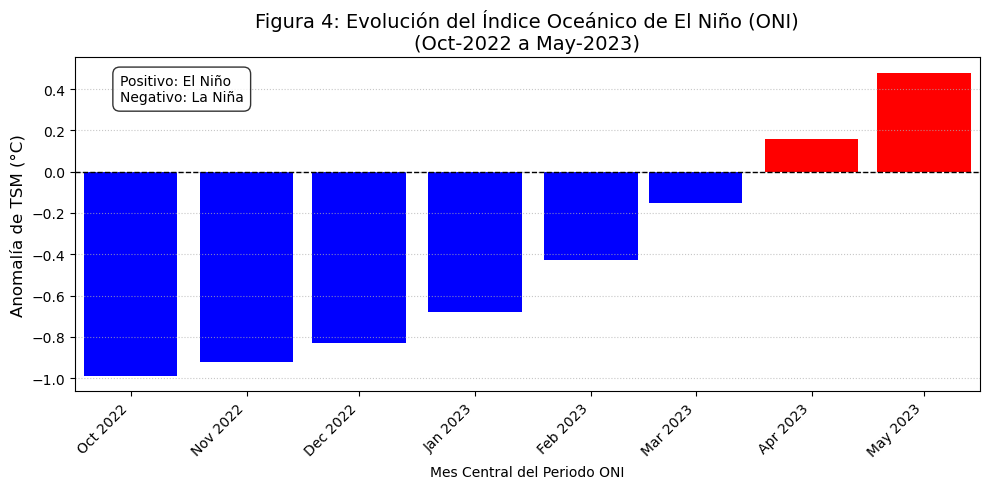

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

print("Iniciando graficación de datos manuales (SIN DESCARGA)...")

# --- 1. DATOS PROPORCIONADOS POR EL USUARIO (ONI - Promedio de 3 meses) ---
# He tomado los valores de Anomalía (-0.99, -0.92, etc.) y las fechas centrales (Octubre, Noviembre, etc.)
data = {
    'Periodo': ['SON 2022', 'OND 2022', 'NDJ 2022', 'DJF 2023', 'JFM 2023', 'FMA 2023', 'MAM 2023', 'AMJ 2023'],
    'Fecha_Central': ['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
    'Nino34_Anomaly': [-0.99, -0.92, -0.83, -0.68, -0.43, -0.15, 0.16, 0.48]
}

# Crear el DataFrame y establecer la fecha
df_nino = pd.DataFrame(data)
df_nino['Date'] = pd.to_datetime(df_nino['Fecha_Central'])
df_nino = df_nino.set_index('Date')
# --------------------------------------------------------------------------

# 2. PREPARACIÓN DE DATOS PARA PLOTEO
values = df_nino['Nino34_Anomaly'].values
dates_mpl = mdates.date2num(df_nino.index.values)

# 3. VISUALIZACIÓN
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Colores: Naranja para El Niño (positivo), Azul para La Niña (negativo)
colors = np.where(values > 0, 'red', 'blue') 

# Ploteo manual de barras
ax.bar(dates_mpl, values, color=colors, edgecolor='none', width=25)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Formato del eje X (Usando la Fecha Central del periodo ONI)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, ha='right')
ax.set_xlim(dates_mpl.min() - 15, dates_mpl.max() + 15)

# Títulos y Etiquetas
plt.title(f"Figura 4: Evolución del Índice Oceánico de El Niño (ONI)\n({df_nino.index.min().strftime('%b-%Y')} a {df_nino.index.max().strftime('%b-%Y')})", fontsize=14)
ax.set_xlabel("Mes Central del Periodo ONI")
ax.set_ylabel("Anomalía de TSM (°C)", fontsize=12)
ax.grid(axis="y", which="major", linestyle=":", alpha=0.7)

# Interpretación
plt.text(
    0.05, 0.95, 
    'Positivo: El Niño\nNegativo: La Niña', 
    transform=ax.transAxes, 
    fontsize=10, 
    verticalalignment='top', 
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

Generando gráfico del Índice Niño 3.4 (SSTA) con estilo SOI...


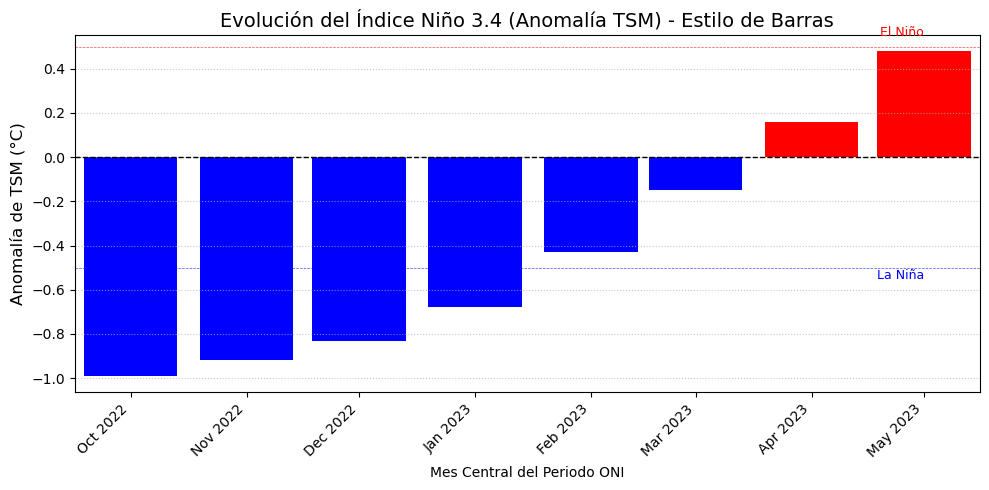

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

print("Generando gráfico del Índice Niño 3.4 (SSTA) con estilo SOI...")

# --- DATOS CONFIRMADOS DE LA NOAA (ONI - Promedio de 3 meses de SSTA) ---
# Usamos el dato de SSTA que ya validamos, ya que es el único que podemos asegurar
data = {
    # Periodos: SON 2022, OND 2022, ..., FMA 2023, MAM 2023, AMJ 2023
    'Fecha_Central': ['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
    'Nino34_Anomaly': [-0.99, -0.92, -0.83, -0.68, -0.43, -0.15, 0.16, 0.48]
}

# Crear el DataFrame y establecer la fecha
df_nino = pd.DataFrame(data)
df_nino['Date'] = pd.to_datetime(df_nino['Fecha_Central'])
df_nino = df_nino.set_index('Date')

values = df_nino['Nino34_Anomaly'].values
dates_mpl = mdates.date2num(df_nino.index.values)

# 1. VISUALIZACIÓN
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Colores: Rojo (El Niño, >0.0°C), Azul (La Niña, <0.0°C)
colors = np.where(values > 0, 'red', 'blue') 

# Ploteo manual de barras
ax.bar(dates_mpl, values, color=colors, edgecolor='none', width=25)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Umbrales ONI (El Niño y La Niña)
umbral_nino = 0.5 
umbral_nina = -0.5
ax.axhline(umbral_nino, color='red', linestyle='--', linewidth=0.5, alpha=0.7)
ax.axhline(umbral_nina, color='blue', linestyle='--', linewidth=0.5, alpha=0.7)

# 2. Formato del eje X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, ha='right')
ax.set_xlim(dates_mpl.min() - 15, dates_mpl.max() + 15)

# 3. Títulos y Etiquetas
plt.title("Evolución del Índice Niño 3.4 (Anomalía TSM) - Estilo de Barras", fontsize=14)
ax.set_xlabel("Mes Central del Periodo ONI")
ax.set_ylabel("Anomalía de TSM (°C)", fontsize=12)
ax.grid(axis="y", which="major", linestyle=":", alpha=0.7)

# Etiquetas de Umbrales (Colocadas estratégicamente)
ax.text(dates_mpl[-1], umbral_nino + 0.05, 'El Niño', color='red', ha='right', fontsize=9)
ax.text(dates_mpl[-1], umbral_nina - 0.05, 'La Niña', color='blue', ha='right', fontsize=9)

plt.tight_layout()
plt.show()